In [1]:
import numpy as np
from scipy.linalg import expm
import scipy
from scipy import integrate
from scipy import io
%matplotlib notebook
import matplotlib.pyplot as plt

In [32]:
def itebd(G_list,l_list,U,chi_max):
    " Updates the G and s matrices using U and the TEBD protocol "
    d = G_list[0].shape[0]

    for ibond in [0,1]:
        ia = np.mod(ibond,2); ib = np.mod(ibond+1,2)

        chi1 = G_list[ia].shape[1]
        chi3 = G_list[ib].shape[2]

        # Construct theta
        theta = np.tensordot(np.diag(l_list[ib]),G_list[ia],axes=(1,1))
        theta = np.tensordot(theta,np.diag(l_list[ia],0),axes=(2,0))
        theta = np.tensordot(theta,G_list[ib],axes=(2,1))
        theta = np.tensordot(theta,np.diag(l_list[ib],0),axes=(3,0))

        # Apply U
        theta = np.tensordot(theta,np.reshape(U,(d,d,d,d)),axes=([1,2],[0,1]))

        # SVD
        theta = np.reshape(np.transpose(theta,(2,0,3,1)),(d*chi1,d*chi3)) # ip a jp b
        X,Y,Z = scipy.linalg.svd(theta, lapack_driver='gesvd')
        Z = Z.T
        chi2 = np.min([np.sum(Y>10.**(-15)), chi_max])

        # Truncate
        l_list[ia]=Y[0:chi2]/np.sqrt(sum(Y[0:chi2]**2))

        X=np.reshape(X[:,0:chi2],(d,chi1,chi2))
        G_list[ia]=np.transpose(np.tensordot(np.diag(l_list[ib]**(-1)),X,axes=(1,1)),(1,0,2))

        Z=np.transpose(np.reshape(Z[:,0:chi2],(d,chi3,chi2)),(0,2,1))
        G_list[ib]=np.tensordot(Z,np.diag(l_list[ib]**(-1)),axes=(2,0))

def site_expectation_value(G_list,l_list,O):
    " Expectation value for a site operator "
    E=[]
    for isite in range(0,2):
        theta = np.tensordot(np.diag(l_list[np.mod(isite-1,2)]),G_list[isite],axes=(1,1))
        theta = np.tensordot(theta, np.diag(l_list[isite]),axes=(2,0))
        theta_O = np.tensordot(theta,O,axes=(1,0)).conj()
        E.append(np.squeeze(np.tensordot(theta_O,theta,axes=([0,1,2],[0,2,1]))).item())
    return(E)

def bond_expectation_value(G_list,l_list,O):
    " Expectation value for a site operator "
    E=[]
    for ibond in range(0,2):
        ia = np.mod(ibond,2); ib = np.mod(ibond+1,2)
        theta = np.tensordot(np.diag(l_list[ib]),G_list[ia],axes=(1,1))
        theta = np.tensordot(theta,np.diag(l_list[ia],0),axes=(2,0))
        theta = np.tensordot(theta,G_list[ib],axes=(2,1))
        theta = np.tensordot(theta,np.diag(l_list[ib],0),axes=(3,0))
        theta_O = np.tensordot(theta,np.reshape(O,(d,d,d,d)),axes=([1,2],[0,1])).conj()
        E.append(np.squeeze(np.tensordot(theta_O,theta,axes=([0,1,2,3],[0,3,1,2]))).item())

    return(E)

def entanglement_entropy(l_list):
    EE=[]
    for i_bond in range(2):
        ee=0
        S=l_list[i_bond]
        for p in range(0,len(S)):
            if S[p]>1e-10:
                ee=ee-2*(S[p]**2)*np.log(S[p])
        EE.append(ee)
    return(np.mean(EE))

######## Define the simulation parameter ######################
chi_max=15; delta=0.005; N=6000;d=2; g=0.5
interaction='Dipolar'

############### Initial state : |0000> ########################
Ga = np.zeros((d,1,1),dtype=float);Ga[1,0,0] = 1.
Gb = np.zeros((d,1,1),dtype=float);Gb[1,0,0] = 1.
G_list = [Ga,Gb]

la = np.zeros(1);la[0] = 1.
lb = np.zeros(1);lb[0] = 1.
l_list = [la,lb]

########### Define Ising Hamiltonian and get U ################
sx = np.array([[0.,1.],[1.,0.]])
sy = np.array([[0.,-1j],[1j,0.]])
sz = np.array([[1.,0.],[0.,-1.]])

glist=np.arange(0,2,0.1)

entropy=[]
Mz=[]
Mx=[]
My=[]

dentropy=[]
dMz=[]

for g in glist:
    print(g)
    if interaction=='Ising':
        H = -(np.kron(sx,sx)) +  g*np.kron(sz,np.eye(2,2))
    elif interaction=='Dipolar':
        H = -(np.kron(sx,sx)-(np.kron(sy,sy)+np.kron(sy,sy))/2) +  g*np.kron(sz,np.eye(2,2))
    else:
        raise NameError('Invalid interaction')
    U = expm(-delta*H)

    for step in range(1, N):
        itebd(G_list,l_list,U,chi_max)
        if step%2000==0:
            print('E_itebd = ', np.mean(bond_expectation_value(G_list,l_list,H)))
    #entropy.append(entanglement_entropy(l_list))
    Mz.append(np.mean(site_expectation_value(G_list,l_list,sz)))
    Mx.append(np.mean(site_expectation_value(G_list,l_list,sx)))
    My.append(np.mean(site_expectation_value(G_list,l_list,sy)))
    if interaction=='Ising':
        H = -(np.kron(sx,sx)) +  (g+0.01)*np.kron(sz,np.eye(2,2))
    elif interaction=='Dipolar':
        H = -(np.kron(sx,sx)-(np.kron(sy,sy)+np.kron(sy,sy))/2) +  (g+0.01)*np.kron(sz,np.eye(2,2))
    U = expm(-delta*H)

    for step in range(1, int(N/10)):
        itebd(G_list,l_list,U,chi_max)
    #dentropy.append((entanglement_entropy(l_list)-entropy[len(entropy)-1])/0.01)
    dMz.append((np.mean(site_expectation_value(G_list,l_list,sz))-Mz[-1])/0.01)

Mz=np.array(Mz)
My=np.array(My)
dMz=np.array(dMz)

0.0
E_itebd =  (-1.27115262201+0j)
E_itebd =  (-1.2711637017+0j)
0.1
E_itebd =  (-1.27905652853+0j)
E_itebd =  (-1.27905660769+0j)
0.2
E_itebd =  (-1.29788382426+0j)
E_itebd =  (-1.29788382482+0j)
0.3
E_itebd =  (-1.32530061992+0j)
E_itebd =  (-1.32530062814+0j)
0.4
E_itebd =  (-1.35993773317+0j)
E_itebd =  (-1.35993773317+0j)
0.5
E_itebd =  (-1.40081364117+0j)
E_itebd =  (-1.40081364117+0j)
0.6
E_itebd =  (-1.44715829213+0j)
E_itebd =  (-1.44715829213+0j)
0.7
E_itebd =  (-1.49833767742+0j)
E_itebd =  (-1.49833767742+0j)
0.8
E_itebd =  (-1.55381482106+0j)
E_itebd =  (-1.55381482106+0j)
0.9
E_itebd =  (-1.61312687295+0j)
E_itebd =  (-1.61312687295+0j)
1.0
E_itebd =  (-1.6758703737+0j)
E_itebd =  (-1.6758703737+0j)
1.1
E_itebd =  (-1.74169105042+0j)
E_itebd =  (-1.74169105042+0j)
1.2
E_itebd =  (-1.81027630535+0j)
E_itebd =  (-1.81027630535+0j)
1.3
E_itebd =  (-1.88134940241+0j)
E_itebd =  (-1.88134940241+0j)
1.4
E_itebd =  (-1.95466478538+0j)
E_itebd =  (-1.95466478538+0j)
1.5
E_itebd =

In [3]:
f = lambda k,gz : (gz+np.cos(k))/np.sqrt(1+gz**2+2*gz*np.cos(k))/np.pi

In [4]:
Mz_exact=[]
dMz_exact=[]

for g in glist:
    Mz_exact.append(integrate.quad(f, 0, np.pi, args=(g,))[0])
    dMz_exact.append((integrate.quad(f, 0, np.pi, args=(g+0.01,))[0]-Mz_exact[-1])/0.01)
    
Mz_exact=np.array(Mz_exact)
dMz_exact=np.array(dMz_exact)

<IPython.core.display.Javascript object>


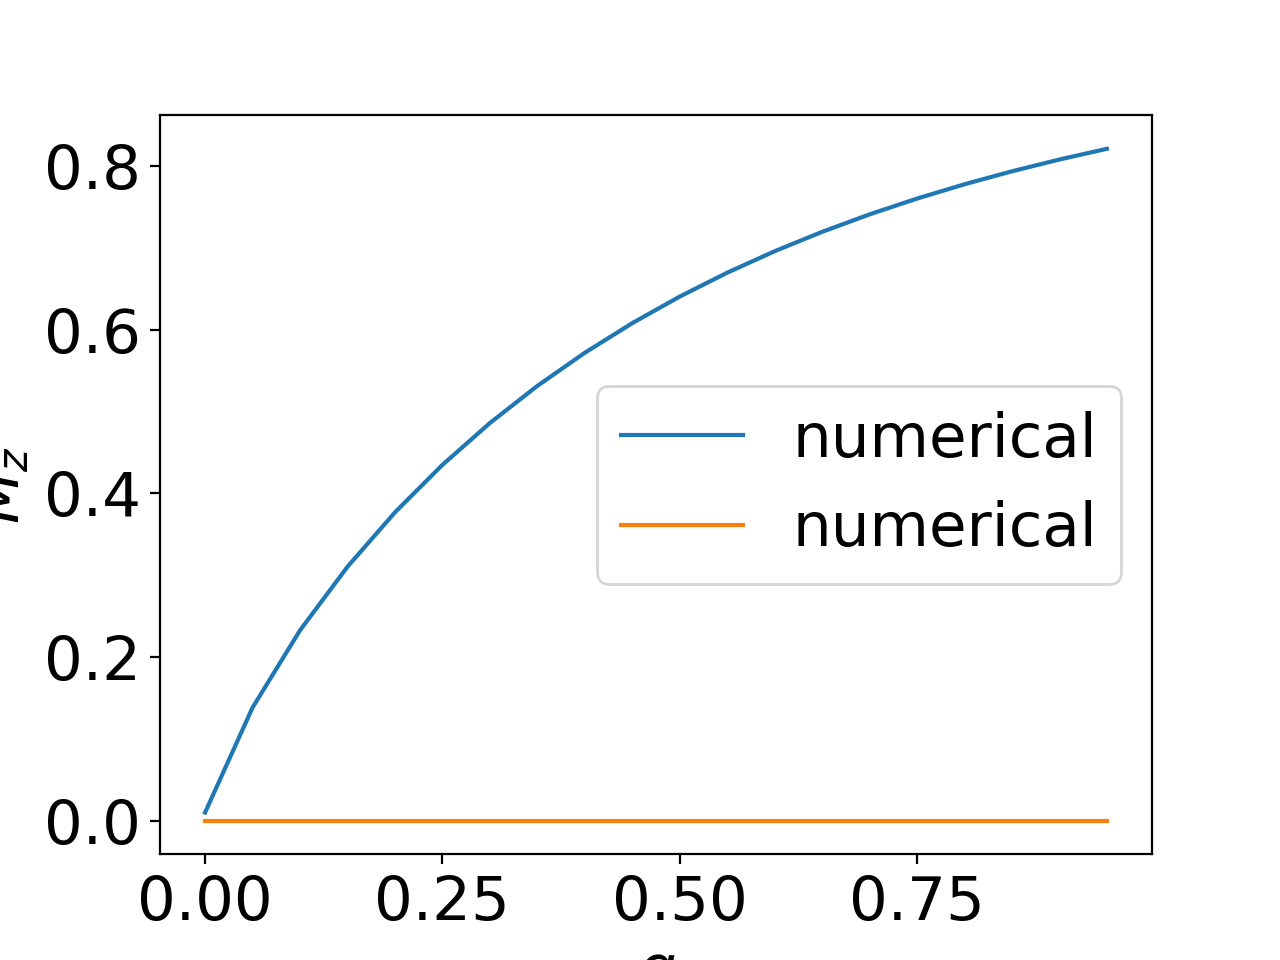

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [33]:
plt.figure(1)
plt.plot(glist/2,-Mz,label='numerical')
plt.plot(glist/2,np.abs(My),label='numerical')
# plt.plot(glist/2,Mz_exact,label='exact')
plt.xlabel('$g$')
plt.ylabel('$M_z$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


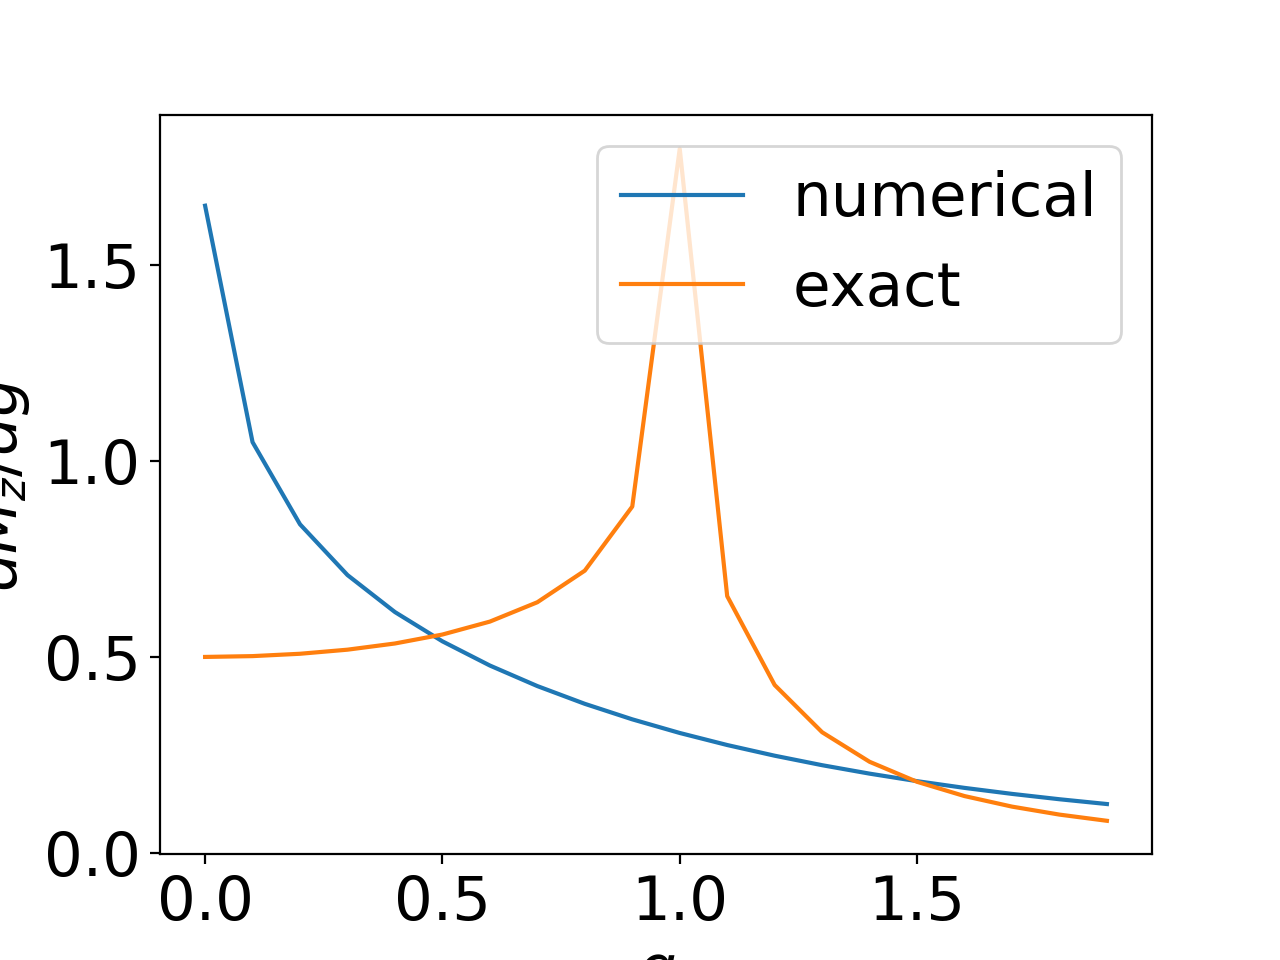

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [27]:
plt.figure(2)
plt.plot(glist,-dMz,label='numerical')
plt.plot(glist,dMz_exact,label='exact')
plt.xlabel('$g$')
plt.ylabel('$dM_z/dg$')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


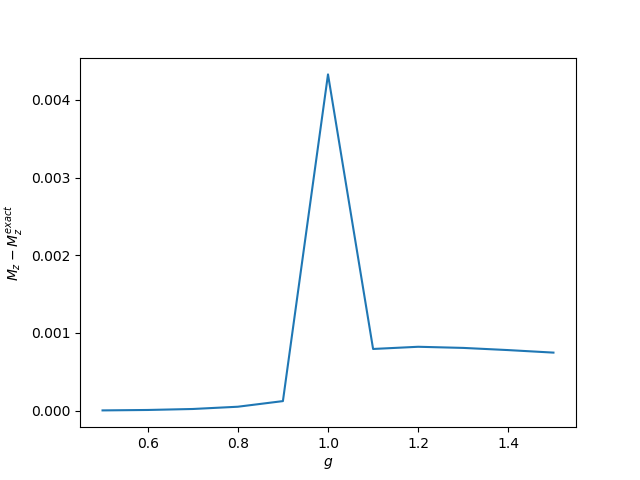

In [21]:
plt.figure(3)
plt.plot(glist,np.array(Mz)+Mz_exact)
plt.xlabel('$g$')
plt.ylabel('$M_z-M_z^{exact}$')
plt.show()

<IPython.core.display.Javascript object>


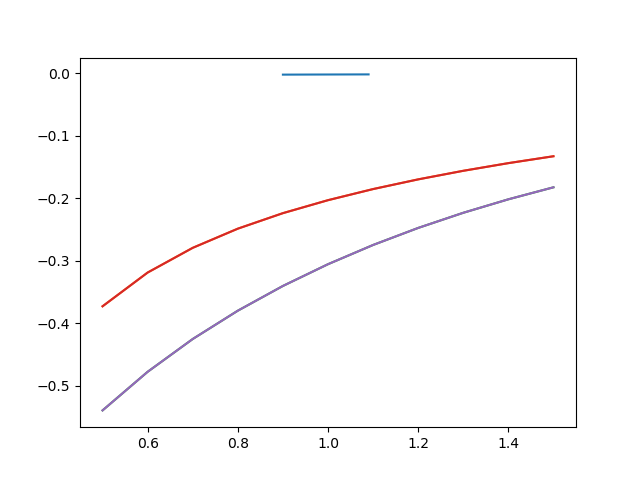

In [15]:
dentropy=[]
for p in range(1,len(entropy)):
    dentropy.append(entropy[p]-entropy[p-1])
plt.figure(2)
plt.plot(glist[0:(len(glist)-1)],dentropy)

In [34]:
from scipy import io
io.savemat('iTEBD_gsMz_dip',{'Mz':Mz,'dMz':dMz,'glist':glist})